In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

os.chdir(os.path.expanduser("~"))  # go to your Home directory
print("CWD:", os.getcwd())


CWD: /Users/jasonlow


In [3]:
SEED = 40

def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
# import wti data
wti = pd.read_csv('../data/wti_prices.csv', parse_dates=['Date'])
wti['log_return'] = np.log(wti['WTI_price'] / wti['WTI_price'].shift(1))

# drop the first row
wti = wti.dropna().reset_index(drop=True)
wti.head()

,Date,WTI_price,log_return
0,1986-02-01,15.46,-0.394190
1,1986-03-01,12.61,-0.203766
2,1986-04-01,12.84,0.018075
3,1986-05-01,15.38,0.180503
4,1986-06-01,13.43,-0.135577


In [5]:
# training, validation, and test sets by 70/15/15
train_size = int(len(wti) * 0.7)
val_size = int(len(wti) * 0.15)

train_df = wti.iloc[:train_size].copy()
val_df   = wti.iloc[train_size:train_size + val_size].copy()
test_df  = wti.iloc[train_size + val_size:].copy()

# check size of each set
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 336
Validation set size: 72
Test set size: 72


Text(0.5, 0, 'Log Return')

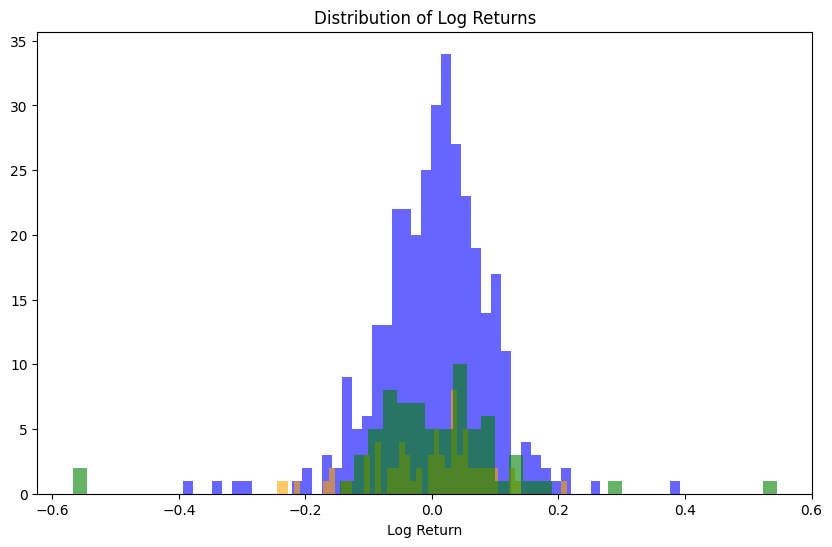

In [6]:
# plot distribution of log returns
plt.figure(figsize=(10, 6))
plt.hist(train_df['log_return'], bins=50, alpha=0.6, color='blue', label='Train')
plt.hist(val_df['log_return'], bins=50, alpha=0.6, color='orange', label='Validation')
plt.hist(test_df['log_return'], bins=50, alpha=0.6, color='green', label='Test')    
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')

# Full training set

In [7]:
# Build LSTM model
# Build LSTM model

def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['log_return']])
    val_scaled = scaler.transform(val[['log_return']])
    test_scaled = scaler.transform(test[['log_return']])
    return train_scaled, val_scaled, test_scaled, scaler

def create_sequences(data, lookback, horizon):

    X, y = [], []
    for t in range(lookback, len(data) - horizon + 1):
        X.append(data[t - lookback:t, :])
        y.append(data[t + horizon - 1, 0])
    return np.array(X), np.array(y)



In [8]:
# scale data
train_scaled1, val_scaled1, test_scaled1, scaler1 = scale_data(train_df, val_df, test_df)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
def build_model(base_lookback, base_units, base_dropout, lr=0.001):
    model = Sequential([
        LSTM(base_units, input_shape=(base_lookback, 1), return_sequences=True),
        Dropout(base_dropout),
        LSTM(base_units // 2),
        Dropout(base_dropout),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse"
    )
    
    return model

In [18]:
def eval_config(train_scaled, val_scaled, config, horizon=1):
    set_all_seeds(SEED)
    tf.keras.backend.clear_session()

    lb = config["lookback"]
    model = build_model(lb, config["units"], config["dropout"])

    X_train, y_train = create_sequences(train_scaled, lb, horizon=horizon)
    X_val, y_val     = create_sequences(val_scaled,   lb, horizon=horizon)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=0
    )

    # use best val loss during training
    best_val = float(np.min(history.history["val_loss"]))
    best_tr  = float(np.min(history.history["loss"]))
    return best_val, best_tr


def greedy_search(train_scaled, val_scaled, base_config, search_space):

    config = base_config.copy()

    best_val, best_tr = eval_config(train_scaled, val_scaled, config)

    history_rows = [{
        **config,
        "train_loss": best_tr,
        "val_loss": best_val,
        "changed": "init"
    }]

    for param, candidates in search_space.items():

        current_best_val = best_val
        current_best_cfg = config.copy()
        current_best_tr  = best_tr

        for cand in candidates:

            trial = config.copy()
            trial[param] = cand

            val, tr = eval_config(train_scaled, val_scaled, trial)

            if val < current_best_val:

                current_best_val = val
                current_best_cfg = trial
                current_best_tr  = tr

        if current_best_val < best_val:

            config = current_best_cfg
            best_val = current_best_val
            best_tr  = current_best_tr

            history_rows.append({
                **config,
                "train_loss": best_tr,
                "val_loss": best_val,
                "changed": param
            })

    return config, pd.DataFrame(history_rows)



In [19]:
# baseline model parameters based on Ly et al. (2021)
base_lookback = 10
base_dropout = 0.1
base_units = 50
base_epoch = 50
base_batch_size = 32

base_config = { 
    "lookback": base_lookback,
    "dropout": base_dropout,
    "units": base_units,
    "epochs": base_epoch,
    "batch_size": base_batch_size
}

search_space = {

    "lookback": [1, 2, 4, 6, 8, 10],

    "dropout": [0.0, 0.001, 0.01, 0.03, 0.1],

    "units": [10, 50, 90, 130, 170],

    "epochs": [20, 40, 60, 80, 100],

    "batch_size": [16, 32, 64]

}

In [20]:
best_config1, greedy_results_df1 = greedy_search(
    train_scaled1,
    val_scaled1,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config1)

print("\nSearch history:")
print(greedy_results_df1)

2026-02-18 23:35:31.354322: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Best configuration:
{'lookback': 1, 'dropout': 0.001, 'units': 170, 'epochs': 100, 'batch_size': 16}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10    0.100     50      50          32    0.713055  1.147747   
1         1    0.100     50      50          32    0.860004  0.987841   
2         1    0.001     50      50          32    0.863369  0.987093   
3         1    0.001    170      50          32    0.862233  0.983892   
4         1    0.001    170     100          32    0.859861  0.982722   
5         1    0.001    170     100          16    0.857111  0.982109   

      changed  
0        init  
1    lookback  
2     dropout  
3       units  
4      epochs  
5  batch_size  


In [30]:
# train final model with best config on train + val, and evaluate on test
final_lookback1 = 1
final_units1 = 170
final_dropout1 = 0.001
final_epochs1 = 100
final_batch_size1 = 16

set_all_seeds(SEED)

model_final = build_model(
    final_lookback1,
    final_units1,
    final_dropout1
)

X_train, y_train = create_sequences(train_scaled1, final_lookback1, horizon=1)
X_val, y_val     = create_sequences(val_scaled1, final_lookback1, horizon=1)

history = model_final.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs1,
    batch_size=final_batch_size1,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled1, final_lookback1, horizon=1)
y_pred_scaled = model_final.predict(X_test)

# inverse transform
y_pred = scaler1.inverse_transform(y_pred_scaled)
y_test_raw = scaler1.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 1ms/step


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse  = mean_squared_error(y_test_raw, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_raw, y_pred)
r2   = r2_score(y_test_raw, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"R2:   {r2:.6f}")

results_df = pd.DataFrame({
    "Model": ["100%"],
    "RMSE": [rmse],
    "MAE": [mae],
    "MSE": [mse],
    "R2": [r2]
})

print(results_df)


RMSE: 0.144787
MAE:  0.080663
MSE:  0.020963
R2:   -0.104862
  Model      RMSE       MAE       MSE        R2
0  100%  0.144787  0.080663  0.020963 -0.104862


# 25% reduction the training set

In [32]:
# reduce 25% the training data 
train_df2 = train_df.iloc[int(len(train_df)*0.25):].copy()

train_scaled2, val_scaled2, test_scaled2, scaler2 = scale_data(train_df2, val_df, test_df)


In [33]:
best_config2, greedy_results_df2 = greedy_search(
    train_scaled2,
    val_scaled2,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config2)

print("\nSearch history:")
print(greedy_results_df2)

Best configuration:
{'lookback': 1, 'dropout': 0.01, 'units': 170, 'epochs': 50, 'batch_size': 16}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10     0.10     50      50          32    0.850680  1.322355   
1         1     0.10     50      50          32    0.924336  1.137983   
2         1     0.01     50      50          32    0.928197  1.137442   
3         1     0.01    170      50          32    0.927573  1.134901   
4         1     0.01    170      50          16    0.927160  1.134362   

      changed  
0        init  
1    lookback  
2     dropout  
3       units  
4  batch_size  


In [35]:
final_lookback2 = 1
final_units2 = 170
final_dropout2 = 0.01
final_epochs2 = 50
final_batch_size2 = 16

set_all_seeds(SEED)

model_final2 = build_model(
    final_lookback2,
    final_units2,
    final_dropout2
)

X_train, y_train = create_sequences(train_scaled2, final_lookback2, horizon=1)
X_val, y_val     = create_sequences(val_scaled2, final_lookback2, horizon=1)

history = model_final2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs2,
    batch_size=final_batch_size2,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled2, final_lookback2, horizon=1)
y_pred_scaled2 = model_final2.predict(X_test)

# inverse transform
y_pred2 = scaler2.inverse_transform(y_pred_scaled2)
y_test_raw2 = scaler2.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 1ms/step


In [36]:
mse2  = mean_squared_error(y_test_raw2, y_pred2)
rmse2 = np.sqrt(mse2)
mae2  = mean_absolute_error(y_test_raw2, y_pred2)
r2_2   = r2_score(y_test_raw2, y_pred2)

print(f"RMSE: {rmse2:.6f}")
print(f"MAE:  {mae2:.6f}")
print(f"MSE:  {mse2:.6f}")
print(f"R2:   {r2_2:.6f}")

results_df = pd.DataFrame({
    "Model": ["100%", "Reduce 25%"],
    "RMSE":  [rmse, rmse2],
    "MAE":   [mae,  mae2],
    "MSE":   [mse,  mse2],
    "R2":    [r2,   r2_2]
})

print(results_df)


RMSE: 0.147919
MAE:  0.082944
MSE:  0.021880
R2:   -0.153175
        Model      RMSE       MAE       MSE        R2
0        100%  0.144787  0.080663  0.020963 -0.104862
1  Reduce 25%  0.147919  0.082944  0.021880 -0.153175


# 50% Reduction of training data

In [37]:
# 50% reduction in training data
train_df3 = train_df.iloc[int(len(train_df)*0.5):].copy()

train_scaled3, val_scaled3, test_scaled3, scaler3 = scale_data(train_df3, val_df, test_df)

In [38]:
best_config3, greedy_results_df3 = greedy_search(
    train_scaled3,
    val_scaled3,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config3)

print("\nSearch history:")
print(greedy_results_df3)

Best configuration:
{'lookback': 1, 'dropout': 0.001, 'units': 170, 'epochs': 80, 'batch_size': 32}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10    0.100     50      50          32    0.793093  1.187546   
1         1    0.100     50      50          32    0.908696  1.004114   
2         1    0.001     50      50          32    0.913055  1.002543   
3         1    0.001    170      50          32    0.910209  1.000638   
4         1    0.001    170      80          32    0.908167  0.998529   

    changed  
0      init  
1  lookback  
2   dropout  
3     units  
4    epochs  


In [39]:
final_lookback3 = 1
final_units3 = 170
final_dropout3 = 0.001
final_epochs3 = 80
final_batch_size3 = 32

set_all_seeds(SEED)

model_final3 = build_model(
    final_lookback3,
    final_units3,
    final_dropout3
)

X_train, y_train = create_sequences(train_scaled3, final_lookback3, horizon=1)
X_val, y_val     = create_sequences(val_scaled3, final_lookback3, horizon=1)

history = model_final3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs3,
    batch_size=final_batch_size3,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled3, final_lookback3, horizon=1)
y_pred_scaled3 = model_final3.predict(X_test)

# inverse transform
y_pred3 = scaler3.inverse_transform(y_pred_scaled3)
y_test_raw3 = scaler3.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 1ms/step


In [40]:
mse3  = mean_squared_error(y_test_raw3, y_pred3)
rmse3 = np.sqrt(mse3)
mae3  = mean_absolute_error(y_test_raw3, y_pred3)
r2_3   = r2_score(y_test_raw3, y_pred3)

print(f"RMSE: {rmse3:.6f}")
print(f"MAE:  {mae3:.6f}")
print(f"MSE:  {mse3:.6f}")
print(f"R2:   {r2_3:.6f}")

results_df = pd.DataFrame({
    "Model": ["100%", "Reduce 25%", "Reduce 50%"], 
    "RMSE":  [rmse, rmse2, rmse3],
    "MAE":   [mae,  mae2, mae3],
    "MSE":   [mse,  mse2, mse3],
    "R2":    [r2,   r2_2, r2_3]
})

print(results_df)




RMSE: 0.144525
MAE:  0.083555
MSE:  0.020887
R2:   -0.100865
        Model      RMSE       MAE       MSE        R2
0        100%  0.144787  0.080663  0.020963 -0.104862
1  Reduce 25%  0.147919  0.082944  0.021880 -0.153175
2  Reduce 50%  0.144525  0.083555  0.020887 -0.100865


# 75% Reduction of training data

In [41]:
# 75% reduction in training data
train_df4 = train_df.iloc[int(len(train_df)*0.75):].copy()

train_scaled4, val_scaled4, test_scaled4, scaler4 = scale_data(train_df4, val_df, test_df)

In [42]:
best_config4, greedy_results_df4 = greedy_search(
    train_scaled4,
    val_scaled4,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config4)

print("\nSearch history:")
print(greedy_results_df4)

Best configuration:
{'lookback': 1, 'dropout': 0.0, 'units': 90, 'epochs': 50, 'batch_size': 16}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10      0.1     50      50          32    0.715111  1.037757   
1         1      0.1     50      50          32    0.784177  0.869293   
2         1      0.0     50      50          32    0.800162  0.868270   
3         1      0.0     90      50          32    0.800189  0.868139   
4         1      0.0     90      50          16    0.797812  0.866445   

      changed  
0        init  
1    lookback  
2     dropout  
3       units  
4  batch_size  


In [43]:
final_lookback4 = 1
final_units4 = 90
final_dropout4 = 0.0
final_epochs4 = 50
final_batch_size4 = 16

set_all_seeds(SEED)

model_final4 = build_model(
    final_lookback4,
    final_units4,
    final_dropout4
)

X_train, y_train = create_sequences(train_scaled4, final_lookback4, horizon=1)
X_val, y_val     = create_sequences(val_scaled4, final_lookback4, horizon=1)

history = model_final4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs4,
    batch_size=final_batch_size4,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled4, final_lookback4, horizon=1)
y_pred_scaled4 = model_final4.predict(X_test)

# inverse transform
y_pred4 = scaler4.inverse_transform(y_pred_scaled4)
y_test_raw4 = scaler4.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 1ms/step


In [44]:
mse4  = mean_squared_error(y_test_raw4, y_pred4)
rmse4 = np.sqrt(mse4)
mae4  = mean_absolute_error(y_test_raw4, y_pred4)
r2_4   = r2_score(y_test_raw4, y_pred4)

print(f"RMSE: {rmse4:.6f}")
print(f"MAE:  {mae4:.6f}")
print(f"MSE:  {mse4:.6f}")
print(f"R2:   {r2_4:.6f}")

results_df = pd.DataFrame({
    "Model": ["100%", "Reduce 25%", "Reduce 50%", "Reduce 75%"], 
    "RMSE":  [rmse, rmse2, rmse3, rmse4],
    "MAE":   [mae,  mae2, mae3, mae4],
    "MSE":   [mse,  mse2, mse3, mse4],
    "R2":    [r2,   r2_2, r2_3, r2_4]
})

print(results_df)




RMSE: 0.146034
MAE:  0.082125
MSE:  0.021326
R2:   -0.123977
        Model      RMSE       MAE       MSE        R2
0        100%  0.144787  0.080663  0.020963 -0.104862
1  Reduce 25%  0.147919  0.082944  0.021880 -0.153175
2  Reduce 50%  0.144525  0.083555  0.020887 -0.100865
3  Reduce 75%  0.146034  0.082125  0.021326 -0.123977


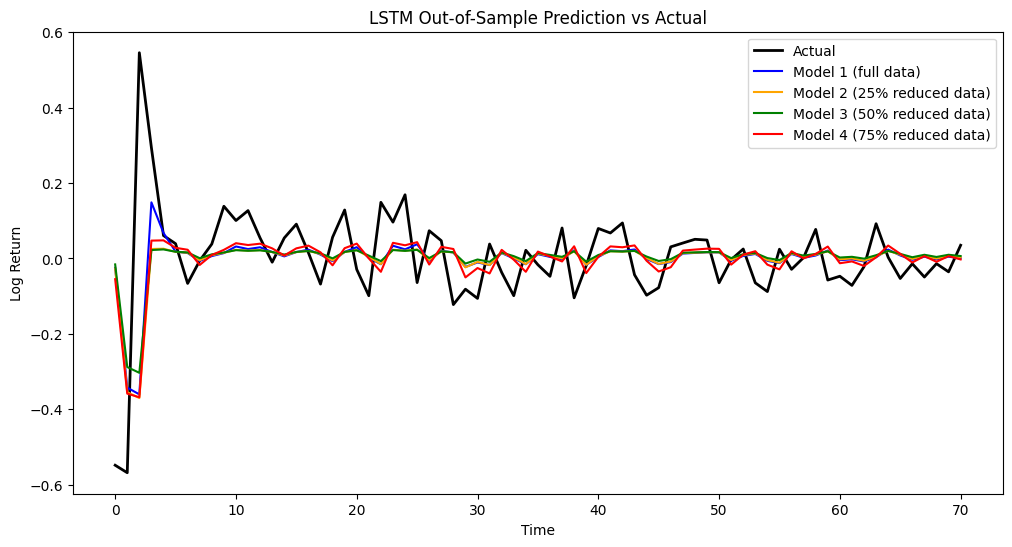

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(y_test_raw, label="Actual", linewidth=2, color = 'black')
plt.plot(y_pred, label="Model 1 (full data)", color='blue')
plt.plot(y_pred2, label="Model 2 (25% reduced data)", color='orange')
plt.plot(y_pred3, label="Model 3 (50% reduced data)", color='green')
plt.plot(y_pred4, label="Model 4 (75% reduced data)", color='red')

plt.title("LSTM Out-of-Sample Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Log Return")

plt.legend()
plt.show()

In [56]:
lookback = 1

dates = test_df["Date"].iloc[lookback:].reset_index(drop=True)

results_df = pd.DataFrame({
    "date": dates,
    "actual": y_test_raw.flatten(),
    "pred_full": y_pred.flatten(),
    "pred_25": y_pred2.flatten(),
    "pred_50": y_pred3.flatten(),
    "pred_75": y_pred4.flatten()
})

results_df.to_csv("lstm_predictions_with_realdata.csv", index=False)
